In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
#loading the CIFAR10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

170508288/170498071 [==============================] - 3s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


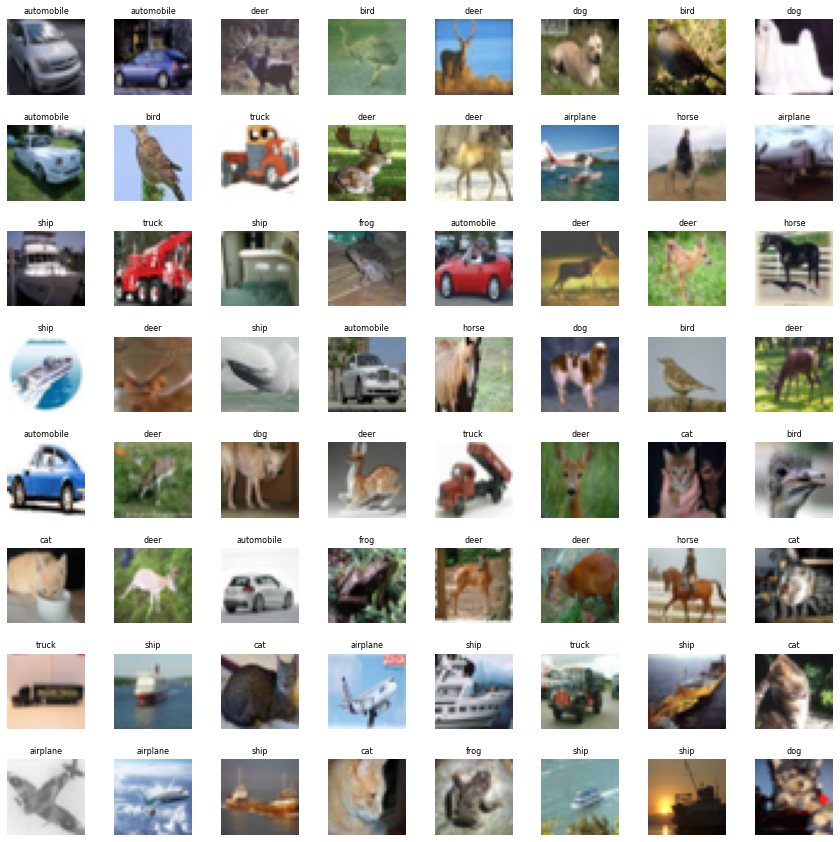

In [17]:
# Giving lables of 10 classes
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Dimensions of the grid
W_grid = 8
L_grid = 8

fig, axes = plt.subplots(L_grid, W_grid, figsize = (15,15))

axes = axes.ravel()

#prints the length of the dataset
n_train = len(X_train)

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid):  

    # Select a random number
    index = np.random.randint(0, n_train)
    # Displaying the image    
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in training set')

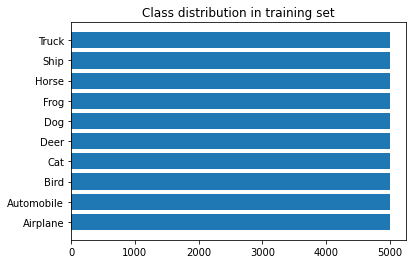

In [4]:
#Class names in dataset
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Distribution of class in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

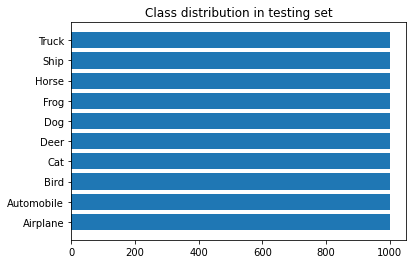

In [5]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Distribution of class in test set')

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

# converting to array of numbers
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [7]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
model = Sequential()

# Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Here comes the Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# Now, Dropout layers
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
#Compiling the mode
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)


In [9]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [11]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

In [12]:
#model building
r = model.fit(train_generator, 
              epochs=50,
#             epochs=40,
#             epochs=20,
#             epochs=10,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test), 
             )

Epoch 1/50
1562/1562 [==============================] - 45s 21ms/step - loss: 1.6322 - accuracy: 0.4096 - precision: 0.6190 - recall: 0.1986 - val_loss: 1.2285 - val_accuracy: 0.5571 - val_precision: 0.7128 - val_recall: 0.3979
Epoch 2/50
1562/1562 [==============================] - 31s 20ms/step - loss: 1.2210 - accuracy: 0.5657 - precision: 0.7299 - recall: 0.4016 - val_loss: 1.1081 - val_accuracy: 0.6222 - val_precision: 0.7497 - val_recall: 0.5153
Epoch 3/50
1562/1562 [==============================] - 31s 20ms/step - loss: 1.0302 - accuracy: 0.6409 - precision: 0.7718 - recall: 0.5122 - val_loss: 0.9506 - val_accuracy: 0.6707 - val_precision: 0.7908 - val_recall: 0.5630
Epoch 4/50
1562/1562 [==============================] - 31s 20ms/step - loss: 0.9296 - accuracy: 0.6800 - precision: 0.7992 - recall: 0.5679 - val_loss: 0.8434 - val_accuracy: 0.7146 - val_precision: 0.7941 - val_recall: 0.6437
Epoch 5/50
1562/1562 [==============================] - 31s 20ms/step - loss: 0.8536 - a

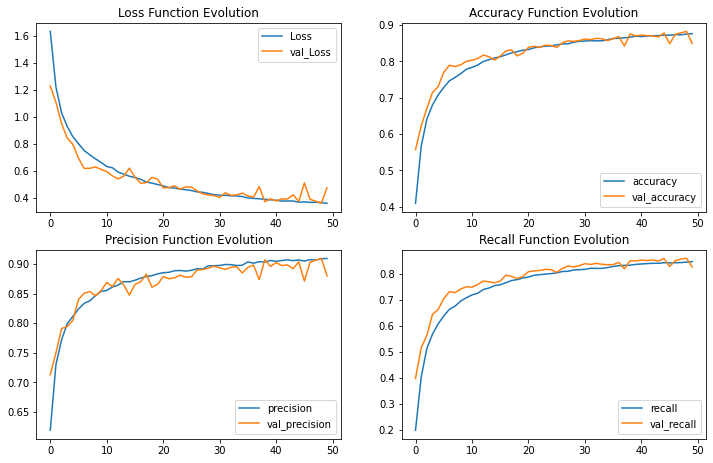

In [13]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function')
plt.legend()

In [14]:
#Evaluating the model to get test accuracy
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

313/313 [==============================] - 2s 5ms/step - loss: 0.4766 - accuracy: 0.8493 - precision: 0.8798 - recall: 0.8264
Test Accuracy : 84.93%
